In [1]:
import pandas as pd
df_movies_all = pd.read_csv("data_analysis/movies.txt", sep=',')
df_cast_people = pd.read_csv("data_analysis/cast.txt", sep=',')
df_movie_companies = pd.read_csv("data_analysis/companies.txt", sep=',')
df_ratings = pd.read_csv("data_analysis/ratings.txt", sep=',')
df_users = pd.read_csv("data_analysis/users.txt", sep=',')

df_users


,user_id,user_age,user_gender,user_occupation,user_zipcode
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213
...,...,...,...,...,...
938,939,26,F,student,33319
939,940,32,M,administrator,02215
940,941,20,M,student,97229
941,942,48,F,librarian,78209


In [2]:
movies_cast_company=pd.read_csv('data_analysis/movies_cast_company.txt')
movies_cast_company

,movie_id_ml,title,release,url,unknown,action,adventure,animation,childrens,comedy,...,mystery,romance,scifi,thriller,war,western,movie_id,keyword,cast,company
0,1,toy story,1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,2445635,"['walkie-talkie', 'boy', 'slow-motion', 'villa...","[{""cast_id"": 193929, ""person_id"": 30260, ""cast...","[{""company_id"": 34, ""name"": ""Warner Home Video..."
1,2,goldeneye,1995,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,1,0,0,1923289,"['car-chase', 'good-versus-evil', '1990s', 'bl...","[{""cast_id"": 586283, ""person_id"": 83451, ""cast...","[{""company_id"": 19, ""name"": ""National Broadcas..."
2,3,four rooms,1995,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,1,0,0,1900170,"['number-in-title', 'title-directed-by-female'...","[{""cast_id"": 629008, ""person_id"": 89615, ""cast...","[{""company_id"": 11745, ""name"": ""Laurenfilm"", ""..."
3,4,get shorty,1995,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,1915485,"['actress', 'father-daughter-relationship', 'r...","[{""cast_id"": 1341029, ""person_id"": 184099, ""ca...","[{""company_id"": 19, ""name"": ""National Broadcas..."
4,5,copycat,1995,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,1,0,0,1788620,"['mother-son-relationship', 'san-francisco-cal...","[{""cast_id"": 643068, ""person_id"": 91412, ""cast...","[{""company_id"": 34, ""name"": ""Warner Home Video..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1310,1421,mi vida loca,1993,http://us.imdb.com/M/title-exact?Mi%20vida%20l...,0,0,0,0,0,0,...,0,0,0,0,0,0,2116298,"['title-directed-by-female', 'death-of-child',...","[{""cast_id"": 137914, ""person_id"": 22471, ""cast...","[{""company_id"": 240, ""name"": ""Home Box Office ..."
1311,1533,de eso no se habla,1993,http://us.imdb.com/M/title-exact?De%20Eso%20No...,0,0,0,0,0,0,...,0,0,0,0,0,0,1809271,"['title-directed-by-female', 'small-town', 'ar...","[{""cast_id"": 140778, ""person_id"": 22879, ""cast...","[{""company_id"": 521, ""name"": ""Argentina Video ..."
1312,1560,coup de torchon,1981,http://us.imdb.com/M/title-exact?Coup%20de%20t...,0,0,0,0,0,0,...,0,0,0,0,0,0,1790668,"['face-slap', 'based-on-novel', 'murder', 'bar...","[{""cast_id"": 801666, ""person_id"": 112621, ""cas...","[{""company_id"": 1705, ""name"": ""Criterion Colle..."
1313,1575,"yo, la peor de todas",1990,"http://us.imdb.com/M/title-exact?Yo,%20la%20Pe...",0,0,0,0,0,0,...,0,0,0,0,0,0,2513027,"['title-directed-by-female', 'marriage', 'moth...","[{""cast_id"": 214873, ""person_id"": 33360, ""cast...","[{""company_id"": 521, ""name"": ""Argentina Video ..."


In [9]:
import random

# Merge the datasets
user_movie_data = df_ratings.merge(movies_cast_company, on="movie_id_ml")
user_data = user_movie_data.merge(df_users, on="user_id")

# Select only numeric columns for aggregation
numeric_user_data = user_data.select_dtypes(include=['number'])

# Perform the aggregation (mean) on the numeric columns only
user_features = numeric_user_data.groupby("user_id").mean()
# Only ratings are aggregated here

# Select a random user
random_user = user_features.sample(n=1)

# Calculate average of non-zero ratings
non_zero_counts = user_features[user_features > 0].count()


non_zero_averages = user_features[user_features > 0].mean()  # Average rating of non-zero values

#print(non_zero_counts)

print(user_data.columns)


Index(['user_id', 'movie_id_ml', 'rating', 'rating_timestamp', 'title',
       'release', 'url', 'unknown', 'action', 'adventure', 'animation',
       'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy',
       'noir', 'horror', 'musical', 'mystery', 'romance', 'scifi', 'thriller',
       'war', 'western', 'movie_id', 'keyword', 'cast', 'company', 'user_age',
       'user_gender', 'user_occupation', 'user_zipcode'],
      dtype='object')


In [45]:
print(user_features)



         movie_id_ml    rating      release  unknown    action  adventure  \
user_id                                                                     
1         139.378261  3.504348  1989.430435      0.0  0.308696   0.173913   
2         262.641509  3.773585  1995.547170      0.0  0.169811   0.056604   
3         321.346154  2.826923  1996.961538      0.0  0.250000   0.057692   
4         291.925926  4.222222  1994.777778      0.0  0.370370   0.222222   
5         297.125828  2.754967  1985.059603      0.0  0.364238   0.218543   
...              ...       ...          ...      ...       ...        ...   
939       527.270833  4.208333  1995.708333      0.0  0.375000   0.229167   
940       356.693878  3.520408  1989.132653      0.0  0.244898   0.112245   
941       308.529412  3.764706  1996.294118      0.0  0.529412   0.352941   
942       418.148148  4.259259  1979.469136      0.0  0.234568   0.148148   
943       389.458599  3.369427  1989.248408      0.0  0.401274   0.216561   

In [44]:
datasets = {
    "user_data": user_data,
    "movies_cast_company": movies_cast_company,
    "df_movies_all": df_movies_all,
    "df_cast_people": df_cast_people,
    "df_movie_companies": df_movie_companies,
    "df_ratings": df_ratings,
    "df_users": df_users,
}
for df_name, df in datasets.items():
    print(f"Dataset: {df_name}")
    print(df.info())
    print(df.describe())
    print("\n")


Dataset: user_data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90851 entries, 0 to 90850
Data columns (total 34 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_id           90851 non-null  int64 
 1   movie_id_ml       90851 non-null  int64 
 2   rating            90851 non-null  int64 
 3   rating_timestamp  90851 non-null  object
 4   title             90851 non-null  object
 5   release           90851 non-null  int64 
 6   url               90851 non-null  object
 7   unknown           90851 non-null  int64 
 8   action            90851 non-null  int64 
 9   adventure         90851 non-null  int64 
 10  animation         90851 non-null  int64 
 11  childrens         90851 non-null  int64 
 12  comedy            90851 non-null  int64 
 13  crime             90851 non-null  int64 
 14  documentary       90851 non-null  int64 
 15  drama             90851 non-null  int64 
 16  fantasy           90851 non-null  int64

In [2]:
import re
import ast

# Function to clean and normalize keywords
def clean_keywords(keywords):
    if pd.isnull(keywords):
        return ""
    # Convert to lowercase and remove special characters
    cleaned = keywords.lower()
    cleaned = re.sub(r'[^a-zA-Z0-9, ]', '', cleaned)  # Keep only alphanumerics and commas
    return cleaned

# Function to extract 'cast_name' from the 'cast' column
def extract_cast_names(cast_data):
    try:
        # Convert the stringified list of dictionaries to Python objects
        cast_list = ast.literal_eval(cast_data)
        formatted_names = []
        for entry in cast_list:
            if "cast_name" in entry:
                # Split the name into surname and first name
                cast_name = entry["cast_name"]
                # Split by comma (i.e., "surname, first_name")
                name_parts = cast_name.split(", ")
                if len(name_parts) == 2:
                    surname, first_name = name_parts
                    # Format as "surname first_name"
                    formatted_names.append(f"{surname} {first_name}")
        return ", ".join(formatted_names)
    except (ValueError, SyntaxError):
        return ""

# Function to extract 'name' from the 'company' column
def extract_company_names(company_data):
    try:
        # Convert the stringified list of dictionaries to Python objects
        company_list = ast.literal_eval(company_data)
        # Extract 'name' from each dictionary in the list
        return ", ".join([entry["name"] for entry in company_list if "name" in entry])
    except (ValueError, SyntaxError):
        return ""


Top Keywords: [(' cultfilm', 40145), (' murder', 35471), (' blockbuster', 29052), (' titlespokenbycharacter', 27177), (' death', 26578), (' violence', 25844), (' blood', 24504), (' basedonnovel', 21935), (' love', 21734), (' friendship', 21404)]
Top Cast: [('', 89910), ('Warshaw Howard Scott', 420), (' Herzog Mark', 212), ('Blum Steve', 158), (' Gilmore Patrick', 158), (' Giacchino Michael', 158), ('Apatow Judd', 106), (' Broderick Matthew', 106), (' Carrey Jim', 106), (' Dick Andy', 106)]
Top Companies: [('', 71545), (' Warner Home Video', 52004), (' United International Pictures (UIP)', 21932), (' Argentina Video Home', 21878), (' Paramount Home Entertainment', 16103), (' Warner Bros.', 14974), (' Paramount Home Video', 10323), (' Columbia TriStar Home Video', 9961), (' Paramount Pictures', 9223), (' MGM/UA Home Entertainment', 8412)]


c:\Users\Dell\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Dell\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:1364: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


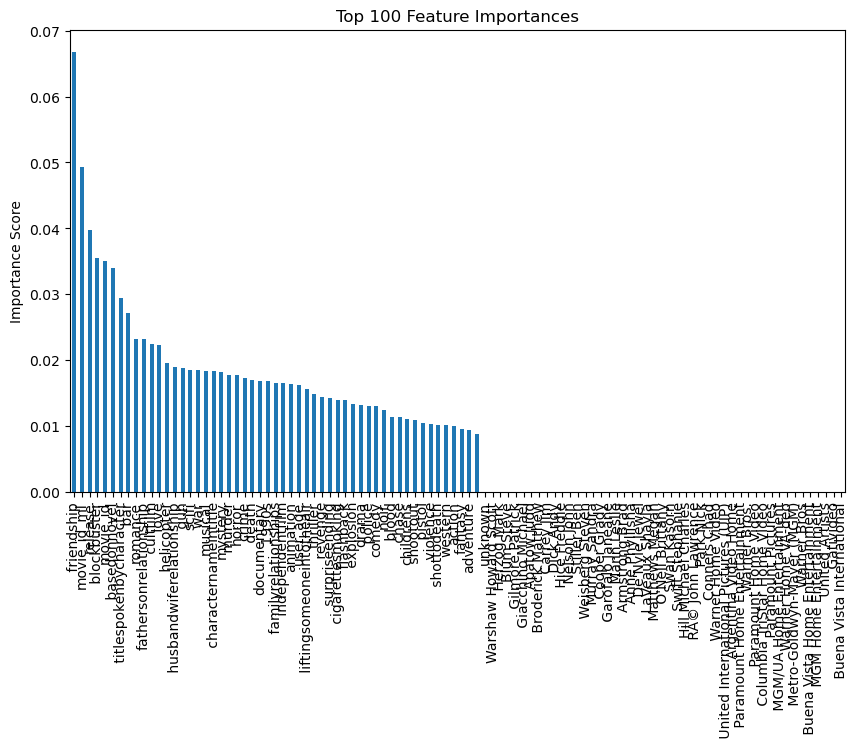

Most important features:
 friendship                          0.066849
movie_id_ml                          0.049272
release                              0.039659
 blockbuster                         0.035407
movie_id                             0.035082
                                       ...   
 O'Neil Brittany                     0.000000
 Swan Kasorn                         0.000000
 Swift Stephanie                     0.000000
Hill Michael Charles                 0.000000
 Sony Pictures Home Entertainment    0.000000
Length: 112, dtype: float64


In [14]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Merge the datasets
user_movie_data = df_ratings.merge(movies_cast_company, on="movie_id_ml")
user_data = user_movie_data.merge(df_users, on="user_id")

# Step 1: Clean keywords
user_data['cleaned_keywords'] = user_data['keyword'].apply(clean_keywords)
user_data["cast_names"] = user_data["cast"].apply(extract_cast_names)
user_data["company_names"] = user_data["company"].apply(extract_company_names)

#keyword 
all_keywords = user_data['cleaned_keywords'].str.split(',').explode()
keyword_counts = Counter(all_keywords)
top_keywords = keyword_counts.most_common(10)
print("Top Keywords:", top_keywords)

# cast
all_cast = user_data['cast_names'].str.split(',').explode()
cast_counts = Counter(all_cast)
top_cast = cast_counts.most_common(10)
print("Top Cast:", top_cast)

# comp
all_comp = user_data['company_names'].str.split(',').explode()
comp_counts = Counter(all_comp)
top_comp = comp_counts.most_common(10)
print("Top Companies:", top_comp)

#Use CountVectorizer with top keywords, cast, and company names for explicit encoding
top_k = 30  # Adjust based on memory constraints
most_common_keywords = [keyword for keyword, _ in keyword_counts.most_common(top_k)]
most_common_cast = [cast for cast, _ in cast_counts.most_common(top_k)]
most_common_companies = [company for company, _ in comp_counts.most_common(top_k)]

# Vectorizing the `cleaned_keywords`, `cast_names`, and `company_names` columns
vectorizer_keywords = CountVectorizer(tokenizer=lambda x: x.split(','), vocabulary=most_common_keywords)
vectorizer_cast = CountVectorizer(tokenizer=lambda x: x.split(','), vocabulary=most_common_cast)
vectorizer_companies = CountVectorizer(tokenizer=lambda x: x.split(','), vocabulary=most_common_companies)

# Transform the columns
keyword_matrix = vectorizer_keywords.fit_transform(user_data['cleaned_keywords'].fillna(''))
cast_matrix = vectorizer_cast.fit_transform(user_data['cast_names'].fillna(''))
company_matrix = vectorizer_companies.fit_transform(user_data['company_names'].fillna(''))

# Convert the sparse matrices to DataFrames
keyword_df = pd.DataFrame(keyword_matrix.toarray(), columns=vectorizer_keywords.get_feature_names_out())
cast_df = pd.DataFrame(cast_matrix.toarray(), columns=vectorizer_cast.get_feature_names_out())
company_df = pd.DataFrame(company_matrix.toarray(), columns=vectorizer_companies.get_feature_names_out())

# Concatenate encoded keywords, cast, and company with user_data
user_data = pd.concat([user_data.reset_index(drop=True), keyword_df, cast_df, company_df], axis=1)

# Remove duplicate columns 
user_data = user_data.loc[:, ~user_data.columns.duplicated()]

# Extract numeric columns
numeric_user_data = user_data.select_dtypes(include=['number'])

# Perform the aggregation (mean) on the numeric columns
user_features = numeric_user_data.groupby("user_id").mean()

# Prepare for Random Forest feature importance
X = user_features.drop("rating", axis=1)  # Drop target column
y = user_features["rating"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importance scores
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)

# Plot the top_n most important features
top_n = 100
top_features = feature_importances.nlargest(top_n)

top_features.plot(kind="bar", figsize=(10, 6))
plt.title(f"Top {top_n} Feature Importances")
plt.ylabel("Importance Score")
plt.show()

# Optionally, print the most important features
print("Most important features:")
print(feature_importances.sort_values(ascending=False))


Number of non-zero rows for each feature:
user_id                                      90851
movie_id_ml                                  90851
rating                                       90851
rating_timestamp                             90851
title                                        90851
                                             ...  
 Cinema International Corporation (CIC)          0
 20th Century Fox Home Entertainment             0
 Twentieth Century Fox Home Entertainment        0
 Columbia TriStar Home Entertainment             0
 Sony Pictures Home Entertainment                0
Length: 126, dtype: int64


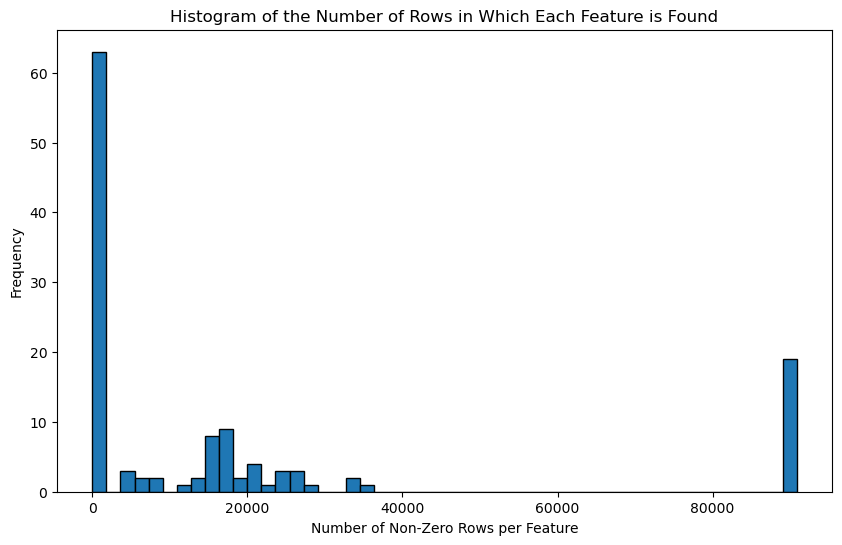

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Calculate the number of non-zero entries for each feature
feature_non_zero_count = (user_data != 0).sum(axis=0)

# Print out the number of rows in which each feature is found
print("Number of non-zero rows for each feature:")
print(feature_non_zero_count)

# Step 2: Plot a histogram of the number of rows each feature is found in
plt.figure(figsize=(10, 6))
plt.hist(feature_non_zero_count, bins=50, edgecolor='black')
plt.title('Histogram of the Number of Rows in Which Each Feature is Found')
plt.xlabel('Number of Non-Zero Rows per Feature')
plt.ylabel('Frequency')
plt.show()



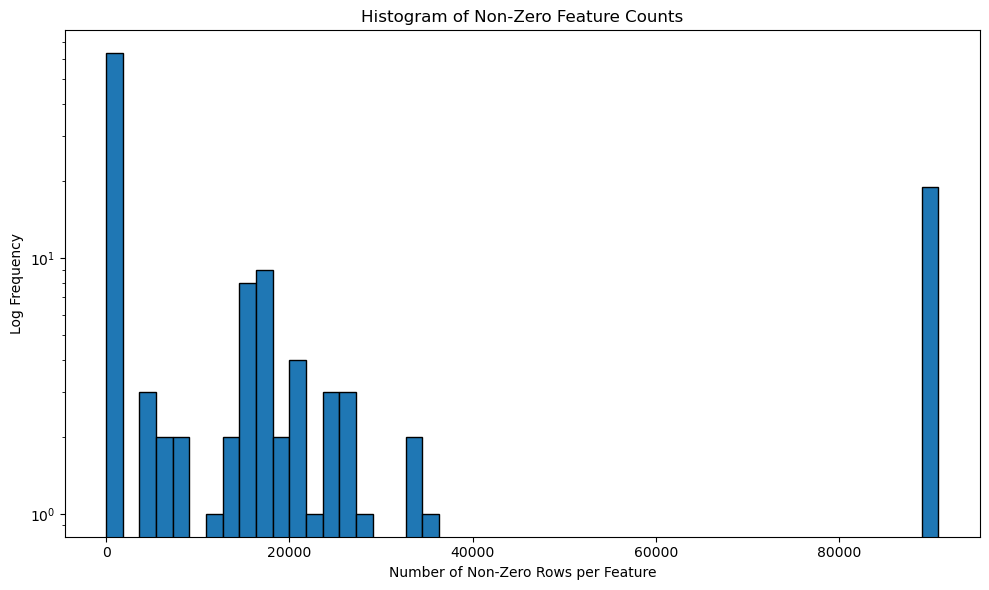

In [7]:
#log scaling
feature_non_zero_count = (user_data != 0).sum(axis=0)
plt.figure(figsize=(10, 6))
plt.hist(feature_non_zero_count, bins=50, edgecolor='black', log=True)
plt.title('Histogram of Non-Zero Feature Counts')
plt.xlabel('Number of Non-Zero Rows per Feature')
plt.ylabel('Log Frequency')
plt.tight_layout()
plt.show()
